# Calibration - broken

Kevin Walchko

---

I made some changes and it broke!!!

We can use `apriltags` to calibrate a camera. 

`cv2.aruco` can detect these tags:

```python
cv2.aruco.DICT_APRILTAG_16H5 = 17
cv2.aruco.DICT_APRILTAG_25h9 = 18
cv2.aruco.DICT_APRILTAG_36H10 = 19
cv2.aruco.DICT_APRILTAG_36H11 = 20
```

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

In [235]:
import numpy as np
import cv2
import cv2.aruco as aruco
from matplotlib import pyplot as plt
import moms_apriltag as apt # generate a target board
import imageio # save the target board to a file for printing
from pathlib import Path
from opencv_camera import __version__ as ocv_version
from opencv_camera import StereoCalibration
from opencv_camera import StereoCamera
from opencv_camera.apriltag.apriltag_marker import Tag
from opencv_camera import ApriltagMarker, ApriltagTargetFinder
from opencv_camera.apriltag.calibrate import ApriltagStereoCalibration
from opencv_camera import coverage
from opencv_camera import visualizeDistortion
from opencv_camera import mosaic
# from opencv_camera import isBlurry
print("OpenCV Camera:", ocv_version)

# from math import asin, atan2,pi
from colorama import Fore

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

OpenCV Camera: 0.11.0


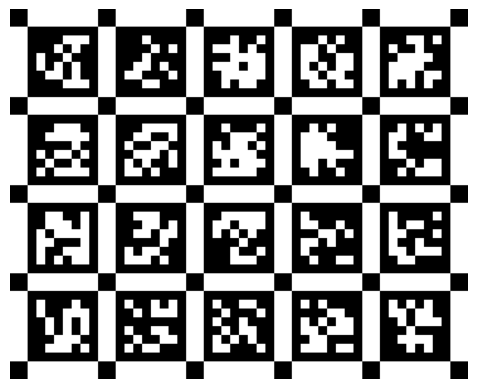

In [208]:
family = "tag36h10"
shape = (4,5)
filename = "apriltag_target.png"
size = 50 # scale image, otherwise each marker is 8x8 pixels

tgt = apt.board(shape, family, size)
imageio.imwrite(filename, tgt)

plt.imshow(tgt, cmap="gray")
plt.axis("off");

Total tags found 20, tag ids:
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


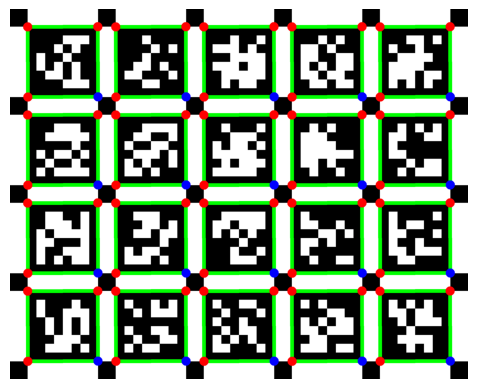

In [209]:
def find(img):
    # ok, img = cv2.threshold(img,150,255,cv2.THRESH_BINARY)
    # img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,51,0)
    
    corners, ids, rejectedImgPts = aruco.detectMarkers(
        img,
        aruco.Dictionary_get(aruco.DICT_APRILTAG_36h10), 
        parameters=aruco.DetectorParameters_create(),
    )
    
    # 36h10 is 8x8
    # min pix/bit sampling 5
    # need each side of tag to 8*5 = 40
    # min_pix = 40
    # for i,c in zip(ids, corners[0]):
    #     # print(c)
    #     dist = np.sqrt((c[0,0] - c[1,0])**2 + (c[0,1] - c[1,1])**2)
    #     if dist < min_pix:
    #         print(f"Bad image {i}: {c}")

    # turn the detections into a list of Tags and draw them on the image
    tags = ApriltagMarker.tagArray(ids, corners)
    at = ApriltagMarker()
    img = at.draw(img, tags)

    ids = ids.flatten()
    ids = sorted(ids)
    print(f"Total tags found {len(ids)}, tag ids:")
    for i in ids:
        print(i, end=" ")
    print("")
    return img


img = find(tgt)
plt.imshow(img)
plt.axis("off");

In [4]:
path = Path("cal_imgs")
files = list(path.rglob("*.png"))
func = lambda f: int(f.stem) # 
files = sorted(files, key=func)

imgs = []
for f in files:
    f = str(f)
    imgs.append(cv2.imread(f, 0))

left: (720, 1280) right: (720, 1280)
Found 39 good images out of 44 images


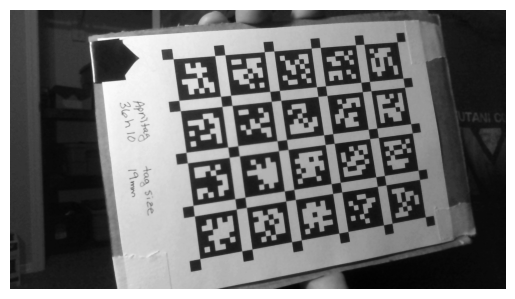

In [34]:
imgsL, imgsR = [], []
h,w = imgs[0].shape

for im in imgs:
    l = im[:, :w//2]
    r = im[:, w//2:]
    
    thres = 300
    bl, val = isblurry(l, thres)
    br, val = isblurry(r, thres)
    if bl or br:
        continue
    
    imgsL.append(l)
    imgsR.append(r)
    
print(f"left: {imgsL[0].shape} right: {imgsR[0].shape}")
print(f"Found {len(imgsL)} good images out of {len(imgs)} images")
plt.imshow(imgsR[0], cmap="gray")
plt.axis("off");

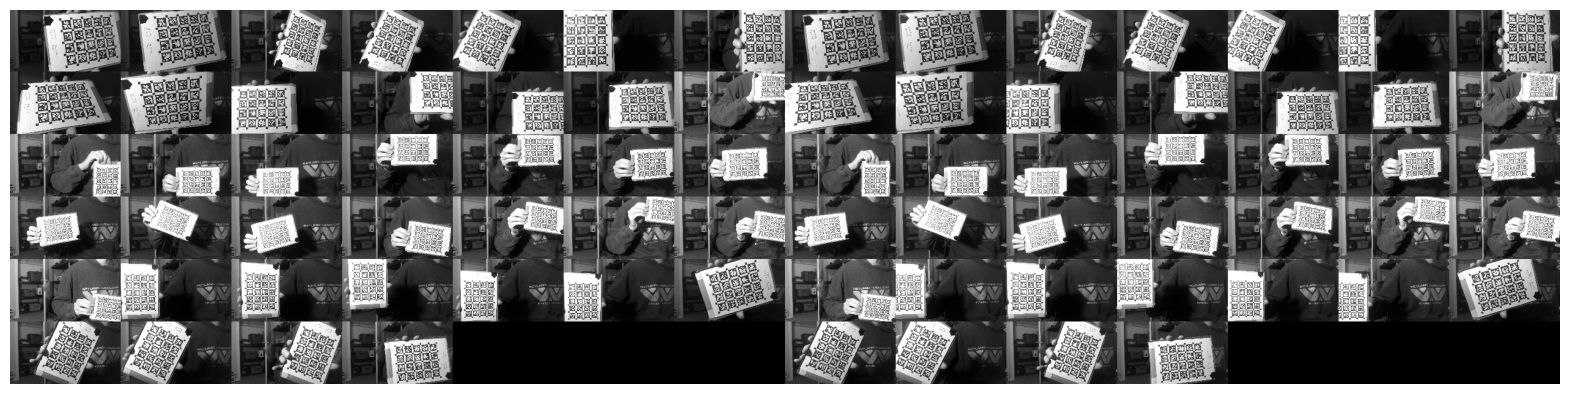

In [229]:
l = mosaic(imgsL)
r = mosaic(imgsR)
plt.figure(figsize=(20,5))
plt.imshow(np.hstack((l,r)),cmap="gray")
plt.axis("off");

In [17]:
# for i, (l, r) in enumerate(zip(imgsL, imgsR)):
#     thres = 100
#     blur, val = isblurry(l, thres)
#     c = Fore.RED if blur is True else ""
#     print(f"{c}{i:3}: left: {blur},{val}{Fore.RESET}", end="   ")
#     blur, val = isblurry(r, thres)
#     c = Fore.RED if blur is True else ""
#     print(f"{c}right: {blur},{val}{Fore.RESET}")

Total tags found 18, tag ids:
0 2 3 4 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Total tags found 15, tag ids:
0 1 2 4 5 6 7 9 10 11 12 13 15 16 17 


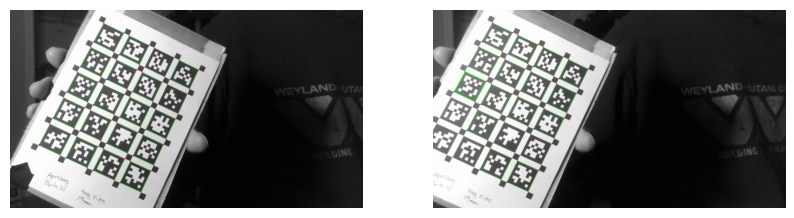

In [143]:
plt.figure(figsize=(10,5))
num = 4
plt.subplot(121); plt.imshow(find(imgsL[num]), cmap="gray");plt.axis("off");
plt.subplot(122); plt.imshow(find(imgsR[num]), cmap="gray");plt.axis("off");

## Calibrate Stereo Camera using Apriltags

In [237]:
board = ApriltagTargetFinder(size=(4,5), scale=0.019, family=aruco.DICT_APRILTAG_36h10)
objpts = board.objectPoints
print(objpts[0])

# [[0.005 0.005 0.   ]
#  [0.024 0.005 0.   ]
#  [0.024 0.024 0.   ]
#  [0.005 0.024 0.   ]]

[[0.005 0.005 0.   ]
 [0.024 0.005 0.   ]
 [0.024 0.024 0.   ]
 [0.005 0.024 0.   ]]


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])


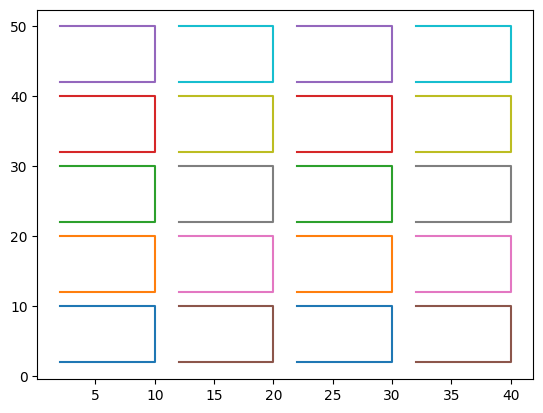

In [238]:
for k,v in objpts.items():
    v = 8/0.019 * v
    v = v.astype(int)
    plt.plot(v[:,0],v[:,1])

print(objpts.keys())

In [239]:
# should find 573 markers in BOTH images
cal = ApriltagStereoCalibration()
ok, cameraModel = cal.calibrate(imgsL, imgsR, board)

Removing markers not seen in both frames:
  Image 0: rejected 2 tags of 17 tags
  Image 1: rejected 3 tags of 16 tags
  Image 3: rejected 1 tags of 19 tags
  Image 4: rejected 5 tags of 18 tags
  Image 5: rejected 5 tags of 20 tags
  Image 7: rejected 3 tags of 17 tags
  Image 8: rejected 6 tags of 15 tags
  Image 9: rejected 4 tags of 19 tags
  Image 13: rejected 2 tags of 15 tags
  Image 14: rejected 4 tags of 17 tags
  Image 18: rejected 1 tags of 19 tags
  Image 19: rejected 1 tags of 19 tags
  Image 20: rejected 1 tags of 20 tags
  Image 25: rejected 2 tags of 18 tags
  Image 27: rejected 1 tags of 19 tags
  Image 28: rejected 3 tags of 15 tags
  Image 29: rejected 5 tags of 18 tags
  Image 32: rejected 2 tags of 17 tags
  Image 33: rejected 6 tags of 19 tags
  Image 34: rejected 7 tags of 14 tags
  Image 35: rejected 7 tags of 11 tags
  Image 36: rejected 4 tags of 14 tags
  Image 37: rejected 3 tags of 12 tags
Total markers found in BOTH cameras: 573


In [240]:
cm = cameraModel # shorten variable name
sc = StereoCamera(
    cm["K1"],cm["d1"],
    cm["K2"],cm["d2"],
    cm["R"],cm["T"],
    cm["F"],
    cm["E"]
)

print(sc)

Camera 1 --------------------------
  focalLength(x,y): 10628.9 2812.7 px 
  principlePoint(x,y): 873.6 407.3 px
  distortionCoeffs: [[ -20.392  133.792    0.087   -0.138 -297.576]]
Camera 2 --------------------------
  focalLength(x,y): 16728.1 4432.8 px 
  principlePoint(x,y): 572.7 372.6 px
  distortionCoeffs: [[-126.673 4967.834    0.887    0.229 1532.803]]
Extrinsic Camera Parameters -------
  Translation between Left/Right Camera: [[ 0.005]
 [-0.06 ]
 [ 0.632]]
  Rotation between Left/Right Camera:
    [[ 1.     0.022  0.015]
     [-0.023  0.999  0.043]
     [-0.014 -0.043  0.999]]
  Essential Matrix:
    [[ 0.015 -0.629 -0.087]
     [ 0.632  0.014  0.005]
     [ 0.06   0.006  0.001]]
  Fundatmental Matrix:
    [[-0.     0.    -0.   ]
     [-0.    -0.     0.017]
     [-0.001 -0.015  1.   ]]



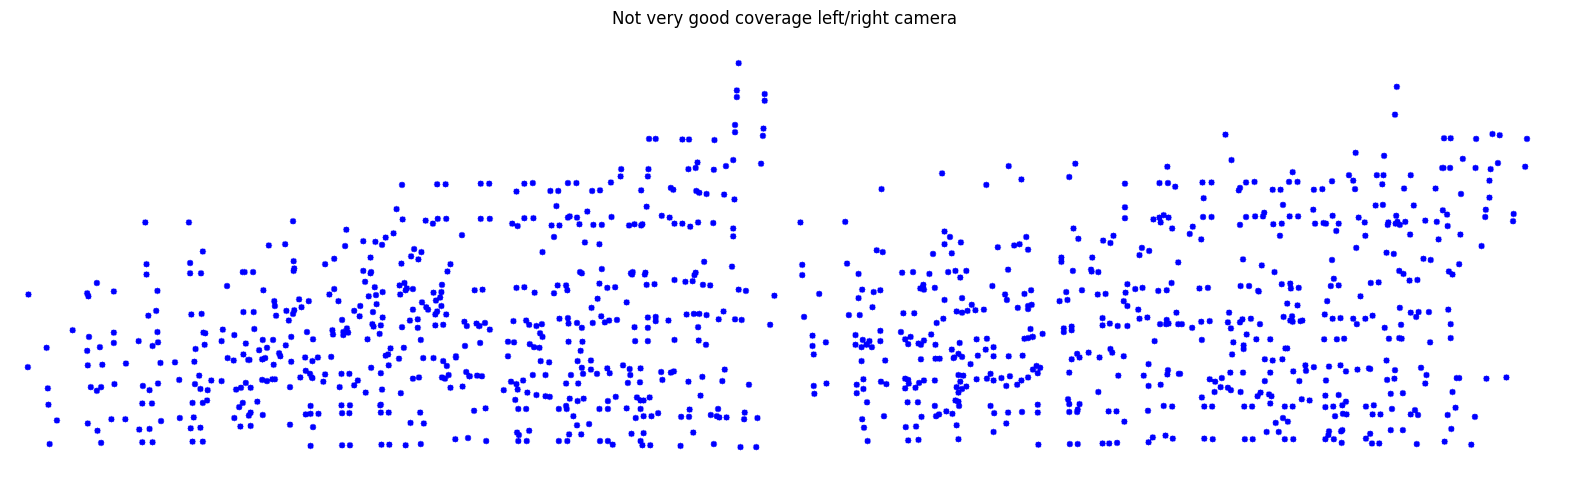

In [241]:
# Looking at the mosaic at the top, looks like there was
# good coverage, not sure what happened???

# draw image points mapped across camera focal plane
imgpoints_l = cameraModel["imgpointsL"]
imgpoints_r = cameraModel["imgpointsR"]

plt.figure(figsize=(20,10))
plt.title("Not very good coverage left/right camera")
l = coverage(imgsL[0].shape[:2], np.vstack(imgpoints_l))
r = coverage(imgsR[0].shape[:2], np.vstack(imgpoints_r))
plt.imshow(np.hstack((l,r)));
plt.axis("off");

# Scratch Work

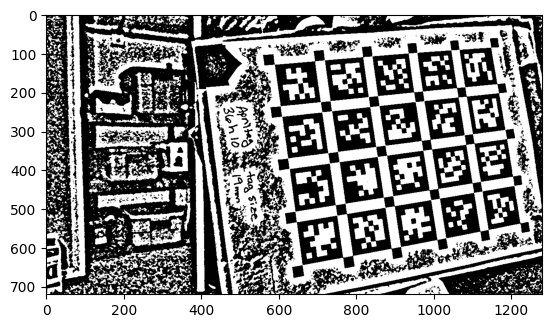

In [173]:
num = 0
# ok, img = cv2.threshold(imgsL[num],150,255,cv2.THRESH_BINARY)
img = cv2.adaptiveThreshold(imgsL[num],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,51,0)
plt.imshow(img,cmap="gray")